In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('./nsl-kdd'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./nsl-kdd\Attack_Types.csv
./nsl-kdd\d_loss.png
./nsl-kdd\g_loss.png
./nsl-kdd\KDDTest.csv
./nsl-kdd\KDDTrain.csv
./nsl-kdd\nslkdd_profile.html
./nsl-kdd\test.parquet
./nsl-kdd\train.parquet


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

# 检查是否有可用的 CUDA 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# DATA Load


In [3]:


data_file_path = './nsl-kdd/'
df = pd.read_csv(data_file_path+'KDDTrain.csv')

In [4]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
df.shape

(125973, 42)

In [6]:
columns = df.columns

In [7]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [8]:
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values}")

columns_with_missing_values = []

for column, count in missing_values.items():
    if count > 0:
        columns_with_missing_values.append(column)

print(f"Columns with missing values: {columns_with_missing_values}")

Total missing values: duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate        

In [9]:
df  = df.dropna()

In [10]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# label 

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
# 处理数据中的字符值
label_encoder = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns

for col in object_cols:
    print(f"{col}: {df[col].dtype}")
    df[col] = label_encoder.fit_transform(df[col])

df.head()

protocol_type: object
service: object
flag: object
label: object


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, RobustScaler
# 处理数据中的字符值
label_encoder = LabelEncoder()

# 
df['label'] = label_encoder.fit_transform(df['label'])


label_mapping = {l: i for i, l in enumerate(label_encoder.classes_)}
print(label_mapping)

col = ["protocol_type","service","flag"]

df[col] = OrdinalEncoder().fit_transform(df[col])


df.head()

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1.0,20.0,9.0,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2.0,44.0,9.0,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1.0,49.0,5.0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1.0,24.0,9.0,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1.0,24.0,9.0,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [14]:
from sklearn.model_selection import train_test_split

to_drop = ['dst_host_srv_serror_rate','num_root','rerror_rate',
            'serror_rate','srv_rerror_rate','srv_serror_rate']

df.drop(to_drop,axis=1,inplace=True)

data_cols = list(df.columns[ df.columns != 'label' ])

scaler = RobustScaler(quantile_range=(0.1, 99.9))
df[data_cols] = scaler.fit_transform(df[data_cols])

columns = df.columns


In [15]:
class3 = df[df['label'] == 3]

class3.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,995.000000,995.0,995.000000,995.000000,995.000000,995.000000,995.0,995.0,995.000000,995.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.0
mean,0.015849,0.0,-0.025635,-0.039196,0.140199,0.352184,0.0,0.0,0.003015,0.277822,...,-0.653397,-0.080944,0.217377,0.001307,0.596915,0.085739,0.023849,0.051116,0.047367,3.0
std,0.055863,0.0,0.138363,0.168102,0.553612,2.711168,0.0,0.0,0.070860,0.412429,...,0.440447,0.139280,0.362322,0.068157,0.473668,0.106648,0.092599,0.202356,0.202389,0.0
min,0.000000,0.0,-0.072464,-0.777778,-0.000020,0.000000,0.0,0.0,0.000000,0.000000,...,-1.000000,-0.244094,-0.510000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,0.000000,0.0,-0.072464,0.000000,0.000132,0.000000,0.0,0.0,0.000000,0.000000,...,-0.988189,-0.177165,-0.160000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
50%,0.000000,0.0,-0.057971,0.000000,0.000132,0.000000,0.0,0.0,0.000000,0.000000,...,-0.964567,-0.110236,0.490000,-0.020000,1.000000,0.070000,0.000000,0.000000,0.000000,3.0
75%,0.000038,0.0,-0.057971,0.000000,0.000538,0.010533,0.0,0.0,0.000000,0.933333,...,-0.025591,-0.047244,0.490000,0.000000,1.000000,0.145000,0.000000,0.000000,0.000000,3.0
max,0.379536,0.0,0.521739,0.111111,2.340103,22.190546,0.0,0.0,2.000000,0.933333,...,0.000000,0.755906,0.490000,0.980000,1.000000,1.000000,1.000000,0.960000,0.960000,3.0


In [16]:
# df_features.head()

# data preprocessing

In [17]:
# 要删除的列名
# object_cols = ['protocol_type', 'service', 'flag', 'label']

# # 记录这些列的索引
# object_indices = [df.columns.get_loc(col) for col in object_cols]
# print("被删除列的索引:", object_indices)

# 删除指定的列
# df_features = df.drop(object_cols, axis=1)
# df_features =df.copy()

# 选择所有整数类型的列
int_columns = df.select_dtypes(include=['int32', 'int64']).columns

# 获取这些列的索引
int_columns_indices = [df.columns.get_loc(col) for col in int_columns]
print("整数类型列的索引:", int_columns_indices)

# df去掉label
df_features  = df.drop('label',axis=1)


# 计算归一化
max_values = df_features.max().to_numpy()
min_values = df_features.min().to_numpy()
mean_values = df_features.mean().to_numpy()
std_values = df_features.std().to_numpy()
df_norm = (df_features - mean_values) / (max_values - min_values + 1e-6)


# 将被删除的列根据原始索引位置加回去
# for i, idx in enumerate(object_indices):
#     if idx < len(df.columns):
#         # 将对应列的值填入
#         df_norm.insert(idx, object_cols[i], df[object_cols[i]])

# df_norm 加上label
df_norm.insert(len(df_norm.columns),'label',df['label'])
# 查看结果
df_norm.describe()




整数类型列的索引: [35]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,...,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000
mean,9.870764e-19,-9.428343e-18,2.101063e-17,1.270508e-17,0.000000,-1.652472e-21,1.454175e-19,4.942433e-18,1.321977e-21,5.851953e-19,...,1.707642e-17,7.126692e-17,-5.471224e-18,-2.890724e-18,3.652183e-18,5.524103e-18,-1.472154e-17,1.271918e-17,1.666044e-17,0.744985
std,6.069994e-02,2.133096e-01,2.369051e-01,2.689362e-01,0.004254,3.069818e-03,1.408606e-02,8.450991e-02,4.788674e-03,2.792166e-02,...,3.890436e-01,4.341280e-01,4.489489e-01,1.889216e-01,3.089968e-01,1.125637e-01,4.447836e-01,3.065572e-01,3.194591e-01,0.653748
min,-6.692094e-03,-5.266004e-01,-4.525571e-01,-6.979989e-01,-0.000033,-1.509928e-05,-1.984550e-04,-7.562460e-03,-3.704496e-05,-2.654660e-03,...,-7.143089e-01,-4.535407e-01,-5.212412e-01,-8.295103e-02,-1.483787e-01,-3.254242e-02,-2.844522e-01,-1.188317e-01,-1.202398e-01,0.000000
25%,-6.692094e-03,-2.660091e-02,-1.627023e-01,-1.979994e-01,-0.000033,-1.509928e-05,-1.984550e-04,-7.562460e-03,-3.704496e-05,-2.654660e-03,...,-3.927406e-01,-4.143251e-01,-4.712412e-01,-8.295103e-02,-1.483787e-01,-3.254242e-02,-2.844522e-01,-1.188317e-01,-1.202398e-01,0.000000
50%,-6.692094e-03,-2.660091e-02,-1.047313e-01,2.020002e-01,-0.000033,-1.509928e-05,-1.984550e-04,-7.562460e-03,-3.704496e-05,-2.654660e-03,...,2.856901e-01,-2.064822e-01,-1.124168e-02,-6.295105e-02,-1.483787e-01,-3.254242e-02,-2.844522e-01,-1.188317e-01,-1.202398e-01,1.000000
75%,-6.692094e-03,-2.660091e-02,2.575871e-01,2.020002e-01,-0.000033,-1.470537e-05,-1.984550e-04,-7.562460e-03,-3.704496e-05,-2.654660e-03,...,2.856901e-01,5.464583e-01,4.787578e-01,-1.295110e-02,-8.837877e-02,-1.254244e-02,7.155468e-01,-1.188317e-01,-1.202398e-01,1.000000
max,9.933070e-01,4.733986e-01,5.474419e-01,3.020002e-01,0.999967,9.999849e-01,9.998005e-01,9.924365e-01,9.999626e-01,9.973450e-01,...,2.856901e-01,5.464583e-01,4.787578e-01,9.170480e-01,8.516203e-01,9.674566e-01,7.155468e-01,8.811673e-01,8.797592e-01,4.000000


In [18]:
from sklearn.model_selection import train_test_split

# 将数据集分为训练集和测试集
train, test = train_test_split(df_norm, test_size=0.2, random_state=42, shuffle=True)
train.shape, test.shape
train.to_parquet('./nsl-kdd/train.parquet', engine='pyarrow')
test.to_parquet('./nsl-kdd/test.parquet', engine='pyarrow')

In [19]:
train = train.to_numpy()
test = test.to_numpy()

X_train = train[:, :-1]  # 训练集的特征
y_train = train[:, -1]  # 训练集的标签
X_test = test[:, :-1]  # 测试集的特征
y_test = test[:, -1]  # 测试集的标签

# 打印划分结果
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(100778, 35) (25195, 35)
(100778,) (25195,)


In [20]:
n = X_train.shape[1]
n

35

# Model define

In [21]:
# 超参数
noise_dim = n  # 噪声向量的维度
embedding_dim = 1  # 标签嵌入的维度
num_classes = 5  # 数据集中类别的总数（假设有5个类别）
output_dim = n  # 生成的数据维度（假设数据是64维向量）
input_dim = n  # 判别器输入的数据维度

In [22]:
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, num_classes, output_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + embedding_dim, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, output_dim)
        )
    # def forward(self, x):
    #     return self.model(x)
    def forward(self, noise, labels):
        # 将噪声和标签嵌入向量结合
        label_embedding = self.label_emb(labels)
        x = torch.cat((noise, label_embedding), dim=1)
        # 通过生成器模型生成数据
        generated_data = self.model(x)
        return generated_data


In [23]:
class Discriminator(nn.Module):
    # 定义判别器类，继承自nn.Module
    def __init__(self,  input_dim, embedding_dim, num_classes):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, 300), # 数据和嵌入标签的总维度作为输入
            nn.LeakyReLU(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(300, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 1), # 最终输出一个标量表示真实/生成
            nn.Sigmoid() # 输出概率
        )
    # def forward(self, x):
    #     return self.model(x)
    def forward(self, data, labels):
        # 通过嵌入层将标签转换为向量
        label_embedding = self.label_emb(labels)
        # 将数据与标签嵌入向量进行拼接
        x = torch.cat((data, label_embedding), dim=1)
        # 通过判别器模型判别数据
        validity = self.model(x)
        return validity

In [24]:
gen = Generator(noise_dim, embedding_dim, num_classes, output_dim)
gen

Generator(
  (label_emb): Embedding(5, 1)
  (model): Sequential(
    (0): Linear(in_features=36, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=300, out_features=35, bias=True)
  )
)

In [25]:
discrim = Discriminator(input_dim, embedding_dim, num_classes)
discrim

Discriminator(
  (label_emb): Embedding(5, 1)
  (model): Sequential(
    (0): Linear(in_features=36, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=300, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

# prameters

In [26]:
epoch = 500
lambda_gp = 5 # the coefficient of the gradient penalty 梯度惩罚项的权重系数

d_step = 1
g_step = 1

discrim.to(device)
gen.to(device)

# optimizerd1 = optim.SGD(discrim.parameters(), lr=0.0001, momentum=0.9)
# optimizerd2 = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.9)

# 修改优化器为 Adam
optimizerd1 = optim.Adam(discrim.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizerd2 = optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.9))


In [27]:
import math
total_size = len(train)
batch_size = 256
batch_num = math.ceil(float(total_size) / batch_size)

def get_dataset(current_batch):
    if(current_batch >= batch_num):
        current_batch = 0
    index_begin = current_batch * batch_size
    index_end = min(index_begin + batch_size, total_size)
    sampled_rows = X_train[index_begin:index_end]
    sampled_label = y_train[index_begin:index_end]
    return torch.from_numpy(sampled_rows).float(), torch.from_numpy(sampled_label).long()

def random_get_dataset(size):
    # 随机采样 size 行
    sample_indices = np.random.choice(train.shape[0], size, replace=False)
    sampled_rows = train[sample_indices]
    return sampled_rows

In [28]:
batch = random_get_dataset(batch_size)
batch.shape

(256, 36)

# 梯度惩罚项的计算函数

In [29]:
# 梯度惩罚项的计算函数
def compute_gradient_penalty(D, real_samples, real_samples_label, fake_samples, fake_samples_label):
    # features 和 label合成
    real_samples_label = real_samples_label.unsqueeze(1)
    fake_samples_label = fake_samples_label.unsqueeze(1)

    real_samples = torch.cat([real_samples, real_samples_label], dim=1)
    fake_samples = torch.cat([fake_samples, fake_samples_label], dim=1)
    # print(real_samples.shape)
    # 获取随机权重
    alpha = torch.rand(real_samples.size(0), 1, device=real_samples.device)
    alpha = alpha.expand_as(real_samples)  # 将随机权重扩展到与输入样本相同的形状

    # print(alpha.shape)

    # 对真实样本和生成样本进行插值
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    features = interpolates[:, :-1]
    label = interpolates[:, -1].long()
    # 获取判别器对插值样本的输出
    d_interpolates = D(features, label)
    
    # 创建中间变量
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)
    
    # 计算插值样本输出的梯度
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # 计算梯度的范数
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

# 为生成器和判别器添加类别条件



In [30]:
# generate noise for generator
def make_noise(batch_size):
    return torch.Tensor(np.random.normal(0,1/3,(batch_size,n))).to(device)

def make_noise_with_labels(size, label):
    noise = make_noise(size)
    label = torch.full((size,), label, dtype=torch.long).to(device)
    return noise, label

# Train

In [31]:
from sklearn.metrics import accuracy_score
final_gen_flows = []
d_loss = []
g_loss = []

torch.manual_seed(42)

# 遍历每个epoch
for nsteps in range(epoch + 1):
    # print("Epoch: " + str(nsteps))
    all_d_loss = 0
    all_g_loss = 0
    
    discrim.train()
    gen.train()
    for i in range(batch_num):

        data_real, data_real_label = get_dataset(i) # real data
        size = data_real.shape[0]

        # print(f"data_real.shape: {data_real.shape}" )

        #discrim
        #real
        data_real_pred = discrim(data_real, data_real_label).flatten() # real decision

        # print(f"data_real_pred: {data_real_pred}" )
        # 计算真实数据的预测值与真实数据之间的平均损失
        data_d_real_loss = -1*data_real_pred.mean()

        #fake
        data_noise, label = make_noise_with_labels(size, 3)

        # print(f"data_noise,: {data_noise},data_noise.shape:{data_noise.shape},label: {label}" )
        data_fake = gen(data_noise, label).detach() # fake data, detach to avoid training G on these labels

        # print(f"data_fake.shape:{data_fake.shape}" )
        
        data_fake_pred = discrim(data_fake, label).flatten() # fake decision
        
        # fake dicision
        data_d_fake_loss = data_fake_pred.mean()

        batch_d_loss = data_d_real_loss + data_d_fake_loss
        # print(f"_________{data_real.shape, data_real_label.shape, data_fake.shape, label.shape}")
        # 计算梯度惩罚项

        print(data_real.shape, data_real_label.shape, data_fake.shape, label.shape)
        gp_loss = compute_gradient_penalty(discrim, data_real, data_real_label, data_fake, label)
        batch_d_loss += gp_loss
        all_d_loss += batch_d_loss.item()

        discrim.zero_grad()
        batch_d_loss.backward() # Only optimizes D's parameters; changes based on stored gradients from backward()
        optimizerd1.step()

        #gen
        for j in range(2):
            data_noise, label = make_noise_with_labels(size, 4) # gen input
            data_fake = gen(data_noise, label) # fake data
            data_fake_pred = discrim(data_fake, label).flatten() # fake dicision
            batch_g_loss = -1*data_fake_pred.mean()
            if(j == 1):
                all_g_loss += batch_g_loss.item()
            gen.zero_grad()
            batch_g_loss.backward()
            optimizerd2.step() # Only optimizes G's parameters
        
        del data_real, data_real_pred, data_d_real_loss
        del data_noise, data_fake, data_fake_pred, data_d_fake_loss
        del batch_d_loss, gp_loss
        del batch_g_loss
        torch.cuda.empty_cache()

    mean_d_loss = all_d_loss / batch_num
    mean_g_loss = all_g_loss / batch_num
    d_loss.append(mean_d_loss)
    g_loss.append(mean_g_loss)
    print('  [Train] mean_d_loss:{:.3f} mean_g_loss:{:.3f}'.format(mean_d_loss, mean_g_loss))
    
    with torch.no_grad():
        discrim.eval()
        gen.eval()
        data_noise, label = make_noise_with_labels(batch_size, 3)
        data_fake = gen(data_noise, label).detach()
        label = torch.unsqueeze(label,1)
        data_fake = torch.cat([data_fake,label],dim=1)
        final_gen_flows = data_fake[0].cpu().numpy() #生成的数据
        
        del data_noise, data_fake
        torch.cuda.empty_cache()

torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) torch.Size([256, 35]) torch.Size([256])
torch.Size([256, 35]) torch.Size([256]) 

KeyboardInterrupt: 

# Save model

In [32]:
discrim.train()
gen.train()



torch.save(discrim, './last/discrim.pth')
torch.save(gen, './last/gen.pth')

In [33]:
print("d_loss")
print(d_loss)

d_loss
[0.70971785765614, 0.6940064596645723, 0.39600535016979665, 0.7419313390545433, 0.5465808218808343, 0.489772581282606, 0.305561046385523, 0.3621532302822558, 0.3085883887588675, 0.12444729777762127, 0.3287257865298218, 0.2156373974181674, 0.30318744556250304, 0.05305499572136681, -0.1351518584840794, -0.06256930575455506, -0.16635652544534751, -0.23987074525374447, -0.22844621039889185, -0.24772553769918867, -0.29015870123799076, -0.16305597342059092, -0.30895638000692816, -0.08636159173728246, 0.3594459271067895, -0.19813513574261352, -0.1652373993759833, -0.3785698452803689, 0.36690675856800853, -0.001801874053659778, -0.5751379622420684, -0.024910582503691544, -0.5886304218908252, -0.23061847251835207, -0.6950328033133811, -0.294911029904627, -0.6085127202538669, 0.09665011391421865, -0.47863913853156387, -0.4422596548565753, -0.6008161289740335, -0.12380129688887427, -0.6608217108975812, -0.473615481617487, -0.31885097005645635, -0.6818710244851669, -0.8204111978789876, -0.4

# show loss

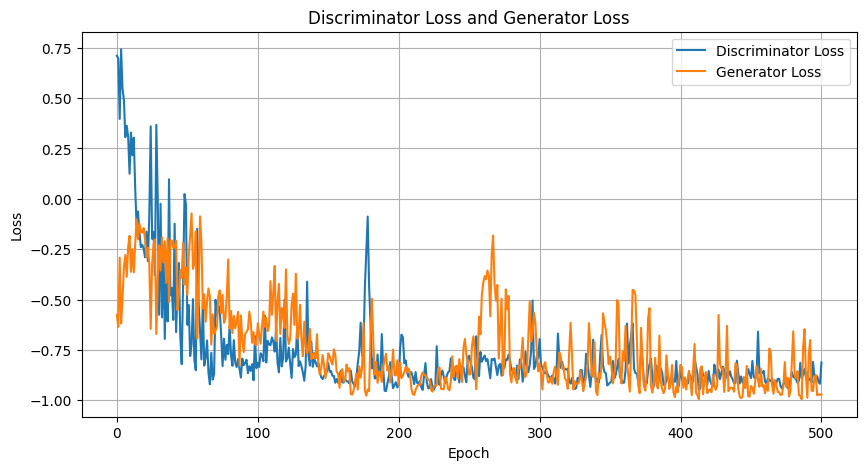

In [34]:
import matplotlib.pyplot as plt
from pathlib import Path

# 创建单个文件夹
Path('last').mkdir(parents=True, exist_ok=True)

# 绘制判别器损失图
plt.figure(figsize=(10, 5))
plt.plot(d_loss, label='Discriminator Loss')
plt.plot(g_loss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss and Generator Loss')
plt.legend()
plt.grid(True)
plt.savefig('./last/d_g_loss.png')  # 保存图像为PNG文件
plt.show()

In [35]:
print("g_loss")
print(g_loss)

g_loss
[-0.575585157132996, -0.6351927335038403, -0.2918783783591187, -0.6188112779326623, -0.4909862685280995, -0.3395573780824652, -0.2788391873018277, -0.38719400168057166, -0.24011459053984113, -0.18378888438089377, -0.36243258153384306, -0.24992229321896656, -0.3645290512606965, -0.225776542195587, -0.1021905510726522, -0.20130580977352364, -0.12065927973395299, -0.16516181734877491, -0.16787051960239707, -0.146056452983527, -0.20052406225864053, -0.2892109799922118, -0.24239842111462265, -0.3196702434818454, -0.6454075631037884, -0.3262546675156821, -0.2262947026848188, -0.20129819276747365, -0.6709133731532217, -0.39505738513496924, -0.23025902816411203, -0.3562038462552322, -0.19148334429651348, -0.31560875900883967, -0.21095647275220925, -0.4178222276005648, -0.1945575309189292, -0.5130220026647682, -0.20480224683048762, -0.20783318404278478, -0.24238360318624733, -0.2427665404360836, -0.2074105907704322, -0.5523315952514029, -0.4792155828799693, -0.35357825247475433, -0.39250

In [36]:
final_gen_flows

array([-1.1978703e+01,  2.1976757e+00,  6.2382464e+00,  2.2637651e+00,
        5.2481890e-03,  8.1487542e-01,  1.5445966e+00,  3.9473057e+00,
        6.2544966e+00, -1.0585853e+01,  5.4729180e+00, -2.1094236e+00,
        2.1169617e+00, -8.4446106e+00, -6.5969744e+00, -3.0079770e-01,
       -4.8498497e+00, -1.9990028e+00, -2.9459643e-01,  1.6269094e+00,
       -1.2705431e+01,  6.3688707e+00, -1.5601461e+00, -6.4765387e+00,
        2.3194699e+00, -8.4095840e+00, -9.6562862e+00,  5.4326487e+00,
       -1.7544162e+00, -1.8817281e+00,  9.3729315e+00,  3.4431071e+00,
       -2.1161597e+00, -2.4249611e+00,  1.0431953e+01,  3.0000000e+00],
      dtype=float32)

In [37]:

final_gen_flows[:-1] = final_gen_flows[:-1]*(max_values - min_values) + mean_values

gen_sample = final_gen_flows

print("gen_sample")
print([float("{:.3f}".format(num)) for num in list(gen_sample)])

gen_sample
[-12.854, 2.224, 6.343, 2.291, 3.321, 4594.621, 1.545, 3.955, 18.764, -27.164, 27.366, -1.714, 3166.607, -8.443, -13.193, -6.461, -9.699, -17.987, 0.0, 1.627, -12.696, 6.519, -1.525, -6.816, 2.383, -8.312, -9.981, 5.661, -1.743, -1.819, 9.521, 3.476, -1.832, -2.306, 10.552, 3.0]


In [38]:
# 要删除的列名
# object_cols = ['protocol_type', 'service', 'flag', 'label']

# # 记录这些列的索引
# object_indices = [df.columns.get_loc(col) for col in object_cols]
# print("被删除列的索引:", object_indices)

# 删除指定的列
# df_features = df.drop(object_cols, axis=1)
# df_features =df.copy()

# 选择所有整数类型的列
int_columns = df.select_dtypes(include=['int32', 'int64']).columns

# 获取这些列的索引
int_columns_indices = [df.columns.get_loc(col) for col in int_columns]
print("整数类型列的索引:", int_columns_indices)

# df去掉label
df_features  = df.drop('label',axis=1)


# 计算归一化
max_values = df_features.max().to_numpy()
min_values = df_features.min().to_numpy()
mean_values = df_features.mean().to_numpy()
std_values = df_features.std().to_numpy()
df_norm = (df_features - mean_values) / (max_values - min_values + 1e-6)


# 将被删除的列根据原始索引位置加回去
# for i, idx in enumerate(object_indices):
#     if idx < len(df.columns):
#         # 将对应列的值填入
#         df_norm.insert(idx, object_cols[i], df[object_cols[i]])

# df_norm 加上label
df_norm.insert(len(df_norm.columns),'label',df['label'])
# 查看结果
print(df_norm.head())




整数类型列的索引: [35]
   duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0 -0.006692      -0.026601 -0.162702  0.202000  -0.000033  -0.000015   
1 -0.006692       0.473399  0.185123  0.202000  -0.000033  -0.000015   
2 -0.006692      -0.026601  0.257587 -0.197999  -0.000033  -0.000015   
3 -0.006692      -0.026601 -0.104731  0.202000  -0.000033  -0.000009   
4 -0.006692      -0.026601 -0.104731  0.202000  -0.000033  -0.000015   

       land  wrong_fragment    urgent       hot  ...  dst_host_count  \
0 -0.000198       -0.007562 -0.000037 -0.002655  ...       -0.126074   
1 -0.000198       -0.007562 -0.000037 -0.002655  ...        0.285690   
2 -0.000198       -0.007562 -0.000037 -0.002655  ...        0.285690   
3 -0.000198       -0.007562 -0.000037 -0.002655  ...       -0.596662   
4 -0.000198       -0.007562 -0.000037 -0.002655  ...        0.285690   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0           -0.355502               -0.351241 

In [39]:

# 选择所有整数类型的列
int_columns = df.select_dtypes(include=['int32', 'int64']).columns

# 获取这些列的索引
int_columns_indices = [df.columns.get_loc(col) for col in int_columns]
print("整数类型列的索引:", int_columns_indices)





整数类型列的索引: [35]


In [40]:
# 将 NumPy 数组转换为 DataFrame
gen_sample_df = pd.DataFrame([gen_sample], columns=columns)
gen_sample_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-12.853764,2.224277,6.342978,2.29085,3.320774,4594.621094,1.544795,3.954868,18.763601,-27.163542,...,-9.981118,5.661332,-1.743175,-1.818777,9.521311,3.47565,-1.831707,-2.306129,10.552194,3.0


In [41]:
# 将指定列转换为 int64 类型
gen_sample_df.iloc[:, int_columns_indices] = \
    gen_sample_df.iloc[:, int_columns_indices].astype(np.int64, errors='ignore')

In [42]:
gen_sample_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-12.853764,2.224277,6.342978,2.29085,3.320774,4594.621094,1.544795,3.954868,18.763601,-27.163542,...,-9.981118,5.661332,-1.743175,-1.818777,9.521311,3.47565,-1.831707,-2.306129,10.552194,3.0


# ganage fake data

In [35]:
# Load the entire discriminator model
discrim = torch.load('./last/discrim.pth')

# Load the entire generator model
gen = torch.load('./last/gen.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to the appropriate device (GPU/CPU)
discrim.to(device)
gen.to(device)



C:\Users\sz124004\AppData\Local\Temp\ipykernel_7704\3770552432.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discrim = torch.load('./last/discrim.pth')
C:\Users\sz1240

Generator(
  (label_emb): Embedding(5, 1)
  (model): Sequential(
    (0): Linear(in_features=36, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=300, out_features=35, bias=True)
  )
)

In [36]:
 # 获取真实数据并生成噪声数据
size = 500
data_noise, label = make_noise_with_labels(size,3)


# 生成伪造数据
data_fake = gen(data_noise,label).detach()

data_fake_pred = discrim(data_fake, label).flatten()

print(f"gen_sample_pred: {data_fake_pred.shape}")

data_fake = data_fake * (max_values - min_values) + mean_values
label = torch.unsqueeze(label,1)
data_fake = torch.cat([data_fake,label],dim=1)
data_fake = data_fake.to('cpu').numpy()

# 将数据转为 DataFrame 并转换指定列为 int64 类型
data_fake_df = pd.DataFrame(data_fake, columns=columns)
data_fake_df.iloc[:, int_columns_indices] = data_fake_df.iloc[:, int_columns_indices].astype(np.int64, errors='ignore')

# print('data_fake_df', data_fake_df)

data_fake_df = pd.DataFrame(data_fake_df, columns=columns)
data_fake_df.describe()

gen_sample_pred: torch.Size([500])


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,-12.773483,2.199786,6.337207,2.262381,6.019175,4562.297739,1.535484,3.924140,18.740409,-27.055976,...,-9.922174,5.666720,-1.739247,-1.798537,9.450311,3.477275,-1.844702,-2.305133,10.497494,3.0
std,0.031558,0.012731,0.028648,0.028530,7.077277,75.380575,0.011947,0.025846,0.080786,0.091907,...,0.035668,0.027288,0.015094,0.014475,0.036824,0.014725,0.023513,0.021126,0.038693,0.0
min,-12.882468,2.167452,6.241534,2.171429,-14.296108,4289.500271,1.488106,3.842845,18.454327,-27.335815,...,-10.037183,5.569928,-1.785132,-1.840463,9.354408,3.437507,-1.900676,-2.376605,10.357162,3.0
25%,-12.794705,2.190278,6.317182,2.242067,1.328706,4511.704618,1.528288,3.906141,18.687373,-27.116637,...,-9.944598,5.647613,-1.749853,-1.808088,9.424433,3.466748,-1.861321,-2.318786,10.470501,3.0
50%,-12.773070,2.199539,6.335320,2.263502,6.254298,4563.182907,1.534671,3.924452,18.736616,-27.052212,...,-9.920379,5.667735,-1.739262,-1.798248,9.450634,3.477769,-1.845455,-2.306442,10.498342,3.0
75%,-12.751822,2.207795,6.357239,2.280797,10.704055,4613.901592,1.542896,3.941708,18.798068,-26.993801,...,-9.898238,5.685852,-1.728714,-1.789139,9.473285,3.487854,-1.829112,-2.291551,10.523508,3.0
max,-12.700562,2.237163,6.421348,2.351109,25.131563,4776.465587,1.569252,4.009966,19.007174,-26.777426,...,-9.832411,5.755121,-1.697364,-1.757216,9.563506,3.519547,-1.769764,-2.235730,10.629943,3.0


# discrim precdiction

In [37]:
data_file_path = './nsl-kdd/'
df = pd.read_csv(data_file_path+'KDDTrain.csv')

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
# 处理数据中的字符值
label_encoder = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns

for col in object_cols:
    print(f"{col}: {df[col].dtype}")
    df[col] = label_encoder.fit_transform(df[col])



from sklearn.model_selection import train_test_split

to_drop = ['dst_host_srv_serror_rate','num_root','rerror_rate',
            'serror_rate','srv_rerror_rate','srv_serror_rate']

df.drop(to_drop,axis=1,inplace=True)

data_cols = list(df.columns[ df.columns != 'label' ])

scaler = RobustScaler(quantile_range=(0.1, 99.9))
df[data_cols] = scaler.fit_transform(df[data_cols])

columns = df.columns

int_columns = df.select_dtypes(include=['int32', 'int64']).columns

# 获取这些列的索引
int_columns_indices = [df.columns.get_loc(col) for col in int_columns]
print("整数类型列的索引:", int_columns_indices)

# df去掉label
df_features  = df.drop('label',axis=1)


# 计算归一化
max_values = df_features.max().to_numpy()
min_values = df_features.min().to_numpy()
mean_values = df_features.mean().to_numpy()
std_values = df_features.std().to_numpy()
df_norm = (df_features - mean_values) / (max_values - min_values + 1e-6)


df_norm
# Convert the data and label to PyTorch tensors
data_tensor = torch.tensor(df_norm.iloc[500, :].values, dtype=torch.float32)
label_tensor = torch.tensor(df.iloc[500, -1], dtype=torch.int64)

data_tensor = data_tensor.unsqueeze(0)
label_tensor = label_tensor.unsqueeze(0)

# Pass the tensors to the discriminator model
data_real_pred = discrim(data_tensor, label_tensor).flatten()

data_real_pred

protocol_type: object
service: object
flag: object
label: object
整数类型列的索引: [35]


tensor([0.9604], grad_fn=<ViewBackward0>)

In [46]:
# gan fake data

In [ ]:

class2_target = 20000
class3_target = 15000
class4_target = 10000

class2_count = 0
class3_count = 0
class4_count = 0

class2_data = pd.DataFrame(columns=columns)
class3_data = pd.DataFrame(columns=columns)
class4_data = pd.DataFrame(columns=columns)
while class2_count < class2_target or class3_count < class3_target or class4_count < class4_target:
    for i in range(2,5,1):
        # 获取真实数据并生成噪声数据
        size = 500
        data_noise, label = make_noise_with_labels(size, i)

        # 生成伪造数据
        data_fake = gen(data_noise,label).detach()

        data_fake_pred = discrim(data_fake, label).flatten()

        print(f"gen_sample_pred: {data_fake_pred.shape}")

        data_fake = data_fake * (max_values - min_values) + mean_values
        label = torch.unsqueeze(label,1)
        data_fake = torch.cat([data_fake,label],dim=1)
        data_fake = data_fake.to('cpu').numpy()

        # 将数据转为 DataFrame 并转换指定列为 int64 类型
        data_fake_df = pd.DataFrame(data_fake, columns=columns)
        data_fake_df.iloc[:, int_columns_indices] = data_fake_df.iloc[:, int_columns_indices].astype(np.int64, errors='ignore')

        # print('data_fake_df', data_fake_df)


        # 将生成的 fake data 分类，分别为 class2, class3, class4
        class2_p = data_fake_df[data_fake_df.iloc[:, -1] == 2]
        class3_p = data_fake_df[data_fake_df.iloc[:, -1] == 3]
        class4_p = data_fake_df[data_fake_df.iloc[:, -1] == 4]

        # 计算当前需要生成的数量并追加到对应的 class DataFrame 中
        if class2_count < class2_target:
            needed_class2 = class2_target - class2_count
            class2_data = pd.concat([class2_data, class2_p.iloc[:needed_class2]], ignore_index=True)
            class2_count += len(class2_p)
            print("class2_data", class2_data.shape)
            print("class2_count", class2_count)

        if class3_count < class3_target:
            needed_class3 = class3_target - class3_count
            class3_data = pd.concat([class3_data, class3_p.iloc[:needed_class3]], ignore_index=True)
            class3_count += len(class3_p)
            print("class3_data", class2_data.shape)
            print("class3_count", class3_count)

        if class4_count < class4_target:
            needed_class4 = class4_target - class4_count
            class4_data = pd.concat([class4_data, class4_p.iloc[:needed_class4]], ignore_index=True)
            class4_count += len(class4_p)
            print("class4_data", class2_data.shape)
            print("class4_count", class4_count)

# 合并生成的 class2, class3, class4 数据
final_fake_data = pd.concat([class2_data, class3_data, class4_data], ignore_index=True)

print(f"Class 2: {class2_count} samples, Class 3: {class3_count} samples, Class 4: {class4_count} samples generated.")


gen_sample_pred: torch.Size([500])
class2_data (500, 36)
class2_count 500
class3_data (500, 36)
class3_count 0
class4_data (500, 36)
class4_count 0
gen_sample_pred: torch.Size([500])
class2_data (500, 36)
class2_count 500
class3_data (500, 36)
class3_count 500
class4_data (500, 36)
class4_count 0
gen_sample_pred: torch.Size([500])
class2_data (500, 36)
class2_count 500
class3_data (500, 36)
class3_count 500
class4_data (500, 36)
class4_count 500
gen_sample_pred: torch.Size([500])
class2_data (1000, 36)
class2_count 1000
class3_data (1000, 36)
class3_count 500
class4_data (1000, 36)
class4_count 500
gen_sample_pred: torch.Size([500])
class2_data (1000, 36)
class2_count 1000
class3_data (1000, 36)
class3_count 1000
class4_data (1000, 36)
class4_count 500
gen_sample_pred: torch.Size([500])
class2_data (1000, 36)
class2_count 1000
class3_data (1000, 36)
class3_count 1000
class4_data (1000, 36)
class4_count 1000
gen_sample_pred: torch.Size([500])
class2_data (1500, 36)
class2_count 1500
cla

In [48]:
print(class2_data.head())
print(class3_data.head())
print(class4_data.head())

   duration  protocol_type   service      flag   src_bytes    dst_bytes  \
0 -9.383882       1.427326  6.078937 -0.402746 -189.995281  5494.869293   
1 -9.423539       1.420883  6.122834 -0.340753 -190.706858  5624.124405   
2 -9.373844       1.411873  6.106917 -0.371597 -191.281974  5489.443769   
3 -9.437190       1.425337  6.075409 -0.372106 -190.121960  5571.335441   
4 -9.398819       1.408463  6.062770 -0.373481 -183.801079  5547.406541   

       land  wrong_fragment    urgent        hot  ...  dst_host_count  \
0  1.620684        4.860380  8.681782 -22.477292  ...       -8.522698   
1  1.636905        4.868592  8.790406 -22.545112  ...       -8.554310   
2  1.617358        4.847972  8.814346 -22.510545  ...       -8.534390   
3  1.618824        4.876114  8.880806 -22.607011  ...       -8.545469   
4  1.597180        4.873781  8.843646 -22.480535  ...       -8.490890   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0            5.525424               -

# bundle the data

In [39]:

# 将原始数据与生成的伪造数据合并
combined_data = pd.concat([df, final_fake_data], ignore_index=True)

combined_data['label'].value_counts()

label
1.0    67343
0.0    45927
2.0    31656
3.0    15995
4.0    10052
Name: count, dtype: int64

# classify nsl_kdd

In [40]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import pickle
import csv

import time

# classify preprocess data

In [41]:
df1 =  combined_data.dropna()

In [42]:
# 处理数据中的字符值
label_encoder = LabelEncoder()
object_cols = df1.select_dtypes(include=['object']).columns

for col in object_cols:
    print(f"{col}: {df1[col].dtype}")
    df1[col] = label_encoder.fit_transform(df1[col])

df1.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,0.0,-0.057971,0.000000,0.000204,0.000000,0.0,0.0,0.0,0.0,...,-0.413386,-0.149606,-0.34,0.01,0.17,0.00,0.00,0.05,0.00,1.0
1,0.0,0.5,0.289855,0.000000,0.000046,0.000000,0.0,0.0,0.0,0.0,...,0.000000,-0.244094,-0.51,0.58,0.88,0.00,0.00,0.00,0.00,1.0
2,0.0,0.0,0.362319,-0.444444,-0.000020,0.000000,0.0,0.0,0.0,0.0,...,0.000000,-0.145669,-0.41,0.03,0.00,0.00,1.00,0.00,0.00,0.0
3,0.0,0.0,0.000000,0.000000,0.000086,0.035093,0.0,0.0,0.0,0.0,...,-0.885827,0.755906,0.49,-0.02,0.03,0.04,0.03,0.00,0.01,1.0
4,0.0,0.0,0.000000,0.000000,0.000071,0.001808,0.0,0.0,0.0,0.0,...,0.000000,0.755906,0.49,-0.02,0.00,0.00,0.00,0.00,0.00,1.0


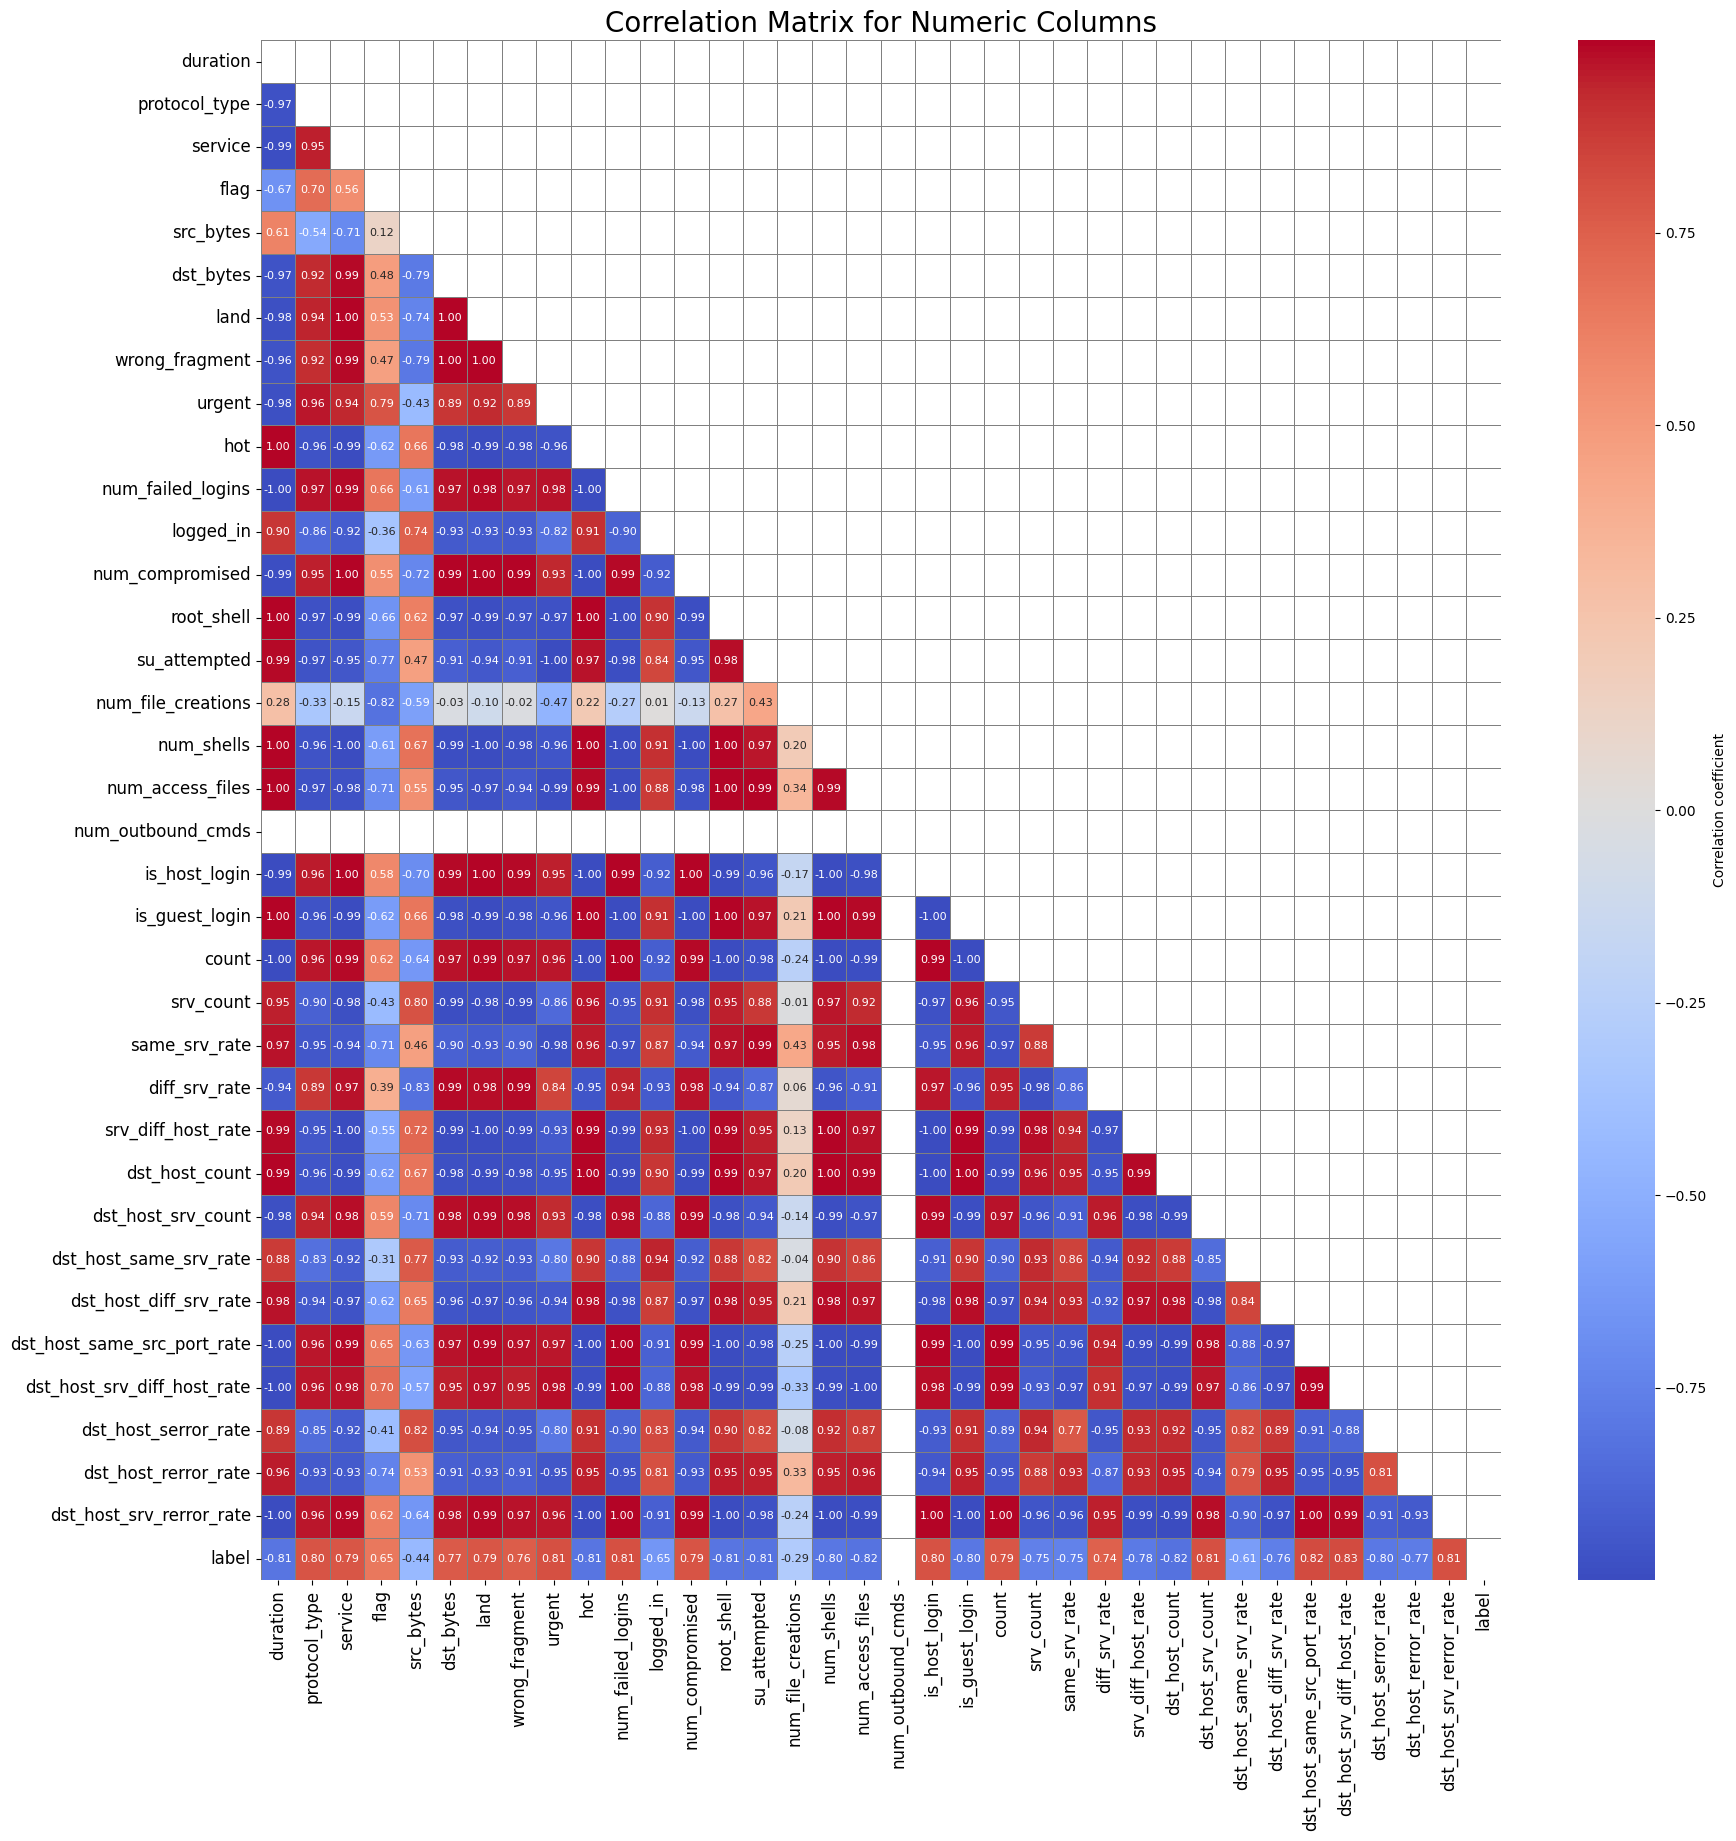

In [43]:
# 计算相关矩阵
correlation_matrix = df1.corr()

# 设置绘图尺寸
plt.figure(figsize=(20, 20))

# 设置颜色映射
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 生成上三角掩码
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 绘制热力图
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8}, cbar_kws={'label': 'Correlation coefficient'}, linewidths=0.5, linecolor='gray')

# 设置标题和标签
plt.title('Correlation Matrix for Numeric Columns', fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# 显示图像
plt.show()

In [44]:
y = df1['label']
X = df1.drop(['label'], axis=1)


# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled, y_resampled = X, y

print(f"Resampled dataset shape: {pd.Series(y_resampled).value_counts()}")

Resampled dataset shape: label
1.0    67343
0.0    45927
2.0    31656
3.0    15995
4.0    10052
Name: count, dtype: int64


In [46]:
# check for Nan values and replace them with 0
X = X_resampled.replace([np.inf, -np.inf],np.nan).fillna(0)
# X = X.drop(['level'], axis=1)

In [47]:
# 标准化
scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)

X_scaler_df = pd.DataFrame(X_scaler, columns=X.columns)

In [48]:
# select features with high variance 除去常量特征即方差为0的特征
selector = VarianceThreshold(threshold=0)

selector.fit(X_scaler_df)

non_counstant_indices = selector.get_support(indices=True)

X_non_counstant = X_scaler_df.iloc[:, non_counstant_indices]

In [49]:
# select bast features with  ANOVA F 
# ANOVA F 统计量，它用于评估每个特征与目标变量 y 之间的线性关系。
k_bast = SelectKBest(score_func=f_classif ,k=20)
X_new = k_bast.fit_transform(X_non_counstant, y)

# 获取选择出的特征的列名
X_non_counstant.columns[k_bast.get_support()]


Index(['duration', 'protocol_type', 'service', 'flag', 'urgent', 'hot',
       'num_failed_logins', 'root_shell', 'su_attempted', 'num_file_creations',
       'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login',
       'count', 'same_srv_rate', 'dst_host_count',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [50]:
selected_features_name = X_non_counstant.columns[k_bast.get_support()]

X_selected = pd.DataFrame(X_new, columns=selected_features_name)

# PCA

In [51]:
pca = PCA()

pca.fit(X_selected)

explained_variance_ratio = pca.explained_variance_ratio_

In [52]:
explained_variance_ratio.cumsum()

array([0.91359155, 0.99011089, 0.99543518, 0.99806645, 0.99887559,
       0.99914565, 0.99939534, 0.99959905, 0.99974494, 0.99986526,
       0.99993209, 0.99996293, 0.99997466, 0.9999835 , 0.99998909,
       0.99999328, 0.99999624, 0.99999803, 0.99999944, 1.        ])

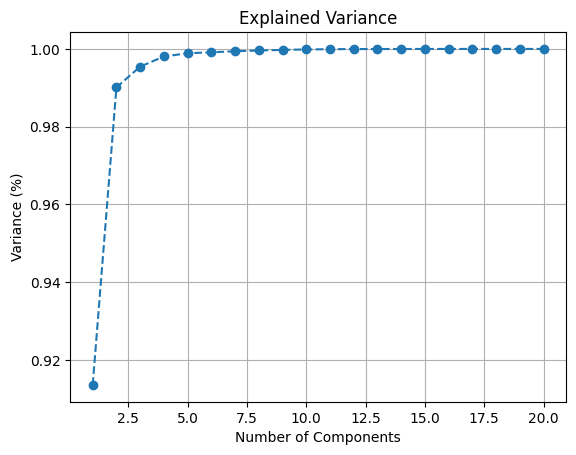

In [53]:
# 绘制累积解释方差比例的图表，以帮助确定保留多少个主成分。
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

In [56]:
n_components = 10

pca = PCA(n_components=n_components)

X_pca = pca.fit_transform(X_selected)

X_pca_df = pd.DataFrame(X_pca, columns=[ f'PC{i}' for i in range(n_components)])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'PC0'),
  Text(0, 1.5, 'PC1'),
  Text(0, 2.5, 'PC2'),
  Text(0, 3.5, 'PC3'),
  Text(0, 4.5, 'PC4'),
  Text(0, 5.5, 'PC5'),
  Text(0, 6.5, 'PC6'),
  Text(0, 7.5, 'PC7'),
  Text(0, 8.5, 'PC8'),
  Text(0, 9.5, 'PC9')])

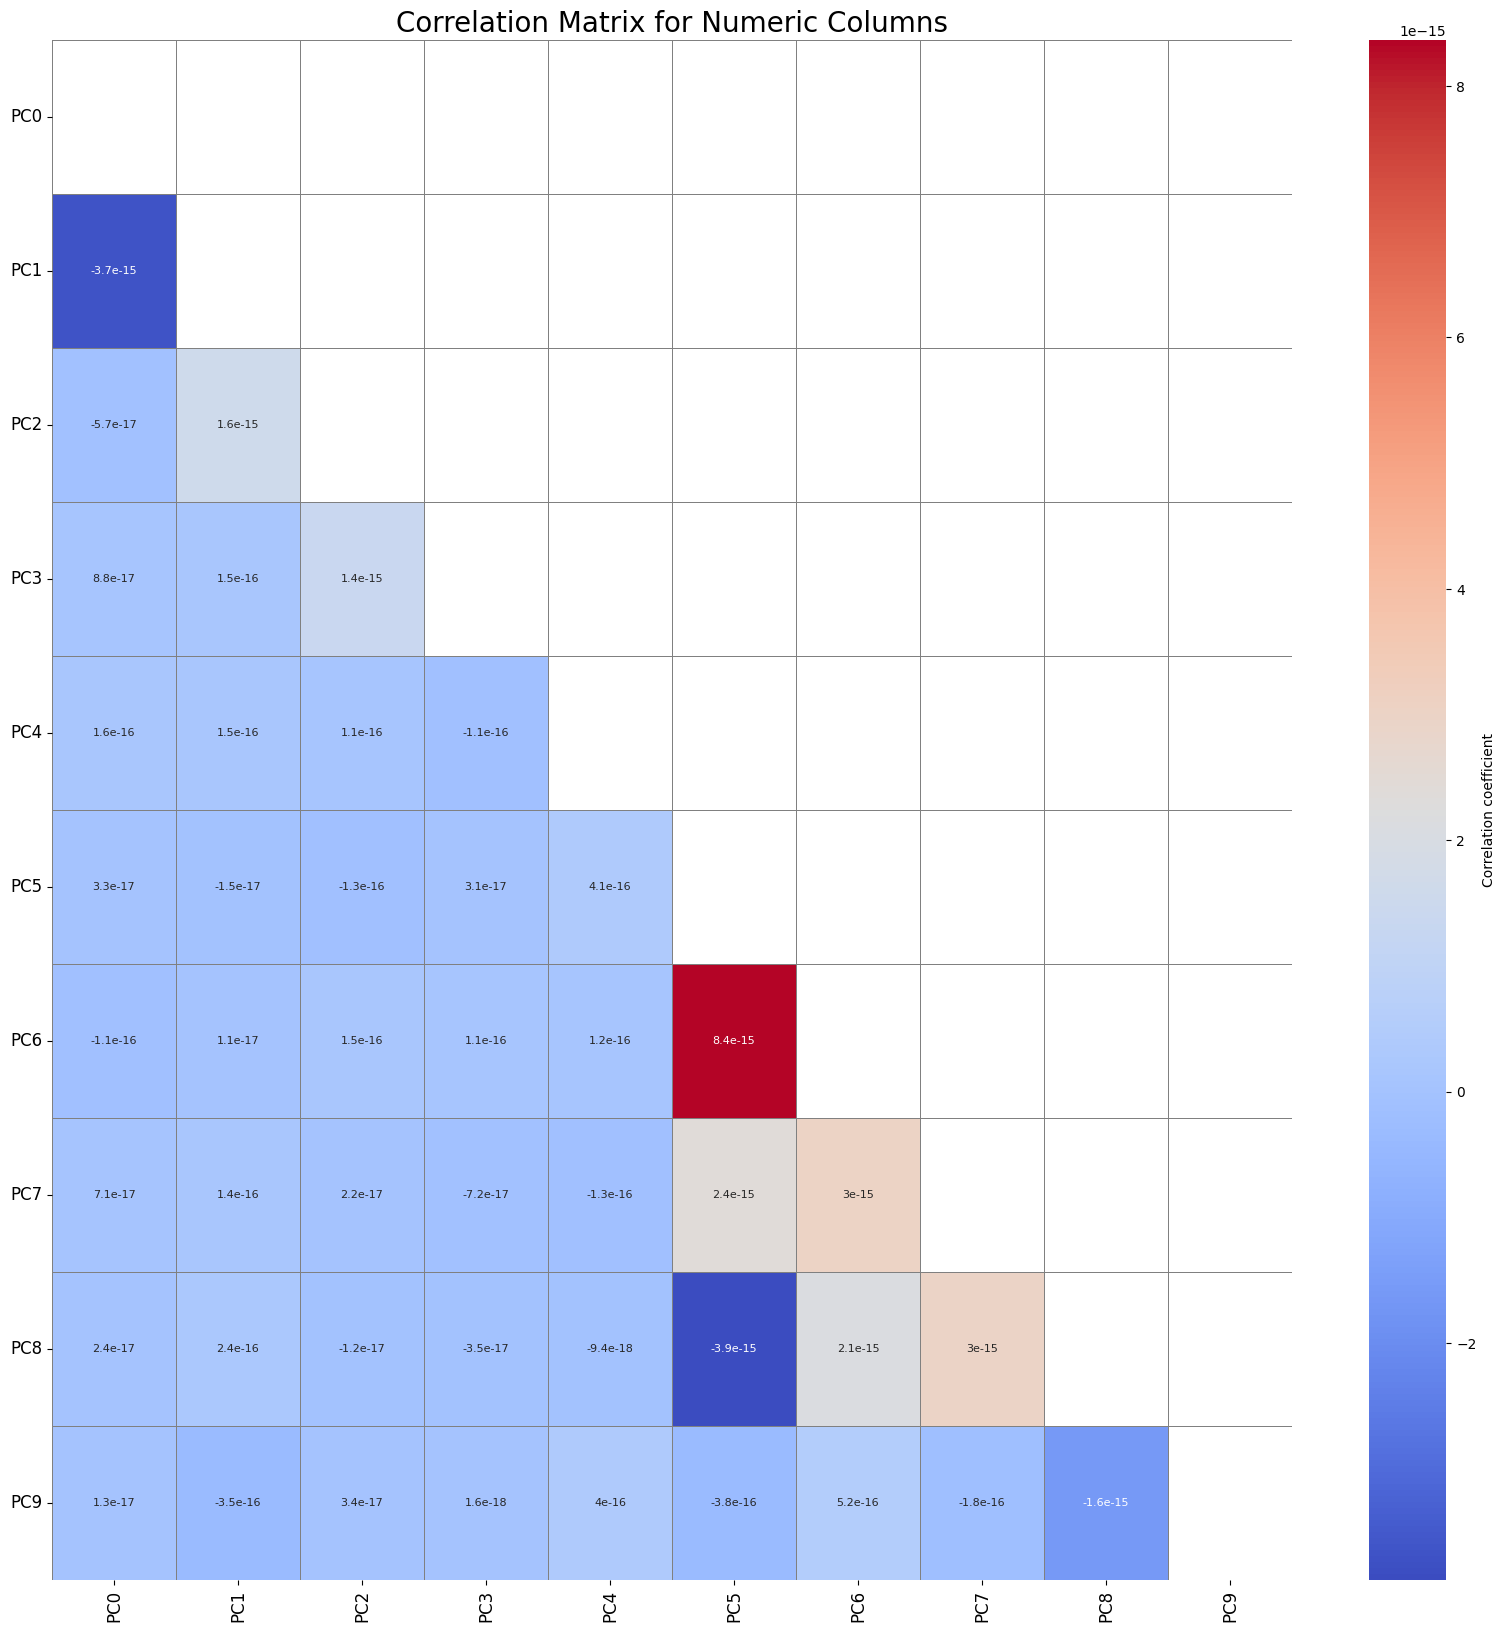

In [57]:
# 计算相关矩阵
correlation_matrix = X_pca_df.corr()

# 设置绘图尺寸
plt.figure(figsize=(20, 20))

# 设置颜色映射
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 生成上三角掩码
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 绘制热力图
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, annot_kws={"size": 8}, cbar_kws={'label': 'Correlation coefficient'}, linewidths=0.5, linecolor='gray')

# 设置标题和标签
plt.title('Correlation Matrix for Numeric Columns', fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Classify Model def

In [58]:


class Model:
    global y
    def __init__(self, data):
        self.data = data
        # X = preprocessing.StandardScaler().fit(self.data).transform(self.data)
        X = self.data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, test_size=0.3)  
    
    # 计算混淆矩阵
    def print_confusion_matrix(self, predicted):
        cm = confusion_matrix(self.y_test, predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    def LogisticRegression(self):
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

        start_time = time.time()
        results_lr = []
        accuracy_list = []
        for solver in solvers:
            LR = LogisticRegression(C=0.03, solver=solver).fit(self.X_train, self.y_train)
            predicted_lr = LR.predict(self.X_test)
            accuracy_lr = accuracy_score(self.y_test, predicted_lr)
            #print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))
            #print('################################################################')
            results_lr.append({'solver' : solver, 'accuracy': str(round(accuracy_lr * 100, 2)) + "%", 
                                  'Coefficients': {'W' : LR.coef_, 'b': LR.intercept_}})
            
            accuracy_list.append(accuracy_lr)
       
        solver_name = solvers[accuracy_list.index(max(accuracy_list))]
        LR = LogisticRegression(C=0.03, solver=solver_name).fit(self.X_train,self.y_train)
        predicted_lr = LR.predict(self.X_test)
        accuracy_lr = accuracy_score(self.y_test, predicted_lr)
        print("Accuracy: %.2f%%" % (accuracy_lr * 100.0), '\n')
        print("########################################################################")
        print('Best solver is : ', solver_name)
        print("########################################################################")
        print(classification_report(predicted_lr, self.y_test), '\n')

        self.print_confusion_matrix(predicted_lr)

        print("########################################################################")
        print("--- %s seconds --- time for LogisticRegression" % (time.time() - start_time))
        
        return LR
        
    def SupportVectorMachine(self):
        start_time = time.time()
        accuracy_list = []
        result_svm = []
        kernels = ['linear', 'poly','rbf', 'sigmoid']
        #kernels = ['rbf']
        for kernel in kernels:
            SVM = svm.SVC(kernel=kernel).fit(self.X_train, self.y_train)
            predicted_svm = SVM.predict(self.X_test)
            accuracy_svm = accuracy_score(self.y_test, predicted_svm)
            result_svm.append({"kernel" : kernel, "accuracy": f"{round(accuracy_svm*100,2)}%"})
            print("Accuracy: %.2f%%" % round((accuracy_svm * 100.0),2))
            print('######################################################################')
            accuracy_list.append(accuracy_svm)
        
        kernel_name = kernels[accuracy_list.index(max(accuracy_list))]
        SVM = svm.SVC(kernel=kernel_name).fit(self.X_train, self.y_train)
        predicted_svm = SVM.predict(self.X_test)
        accuracy_svm = accuracy_score(self.y_test, predicted_svm)
        print(f"Accuracy of SVM model {round(accuracy_svm,2)*100}%", '\n')
        print("########################################################################")
        print('best kernel is : ', kernel_name)
        print("########################################################################")
        print(classification_report(predicted_svm, self.y_test))

        self.print_confusion_matrix(predicted_svm)

        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))
        return SVM

    def KNearetsNeighbor(self):
        start_time = time.time()
        Ks = 12
        accuracy_knn = np.zeros((Ks-1))
        std_acc = np.zeros((Ks-1))
        #print(accuracy_knn)
        for n in range(1,Ks):

            #Train Model and Predict  
            neigh = KNeighborsClassifier(n_neighbors = n).fit(self.X_train,self.y_train)
            yhat=neigh.predict(self.X_test)
            accuracy_knn[n-1] = metrics.accuracy_score(self.y_test, yhat)


            std_acc[n-1]=np.std(yhat==self.y_test)/np.sqrt(yhat.shape[0])

        #print(accuracy_knn,'\n\n') # courseranyn ozinde tek osy gana jazylyp turdy
        #print(std_acc)
        #accuracy_knn[0] = 0
        plt.figure(figsize=(10,6))
        plt.plot(range(1,Ks),accuracy_knn,'g')
        plt.fill_between(range(1,Ks),accuracy_knn - 1 * std_acc,accuracy_knn + 1 * std_acc, alpha=0.10)
        plt.fill_between(range(1,Ks),accuracy_knn - 3 * std_acc,accuracy_knn + 3 * std_acc, alpha=0.10,color="green")
        plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
        plt.ylabel('Accuracy ')
        plt.xlabel('Number of Neighbors (K)')
        plt.tight_layout()
        plt.show()
        
        
        knnc = KNeighborsClassifier()
        knnc_search = GridSearchCV(knnc, param_grid={'n_neighbors': [2, 4, 6],
                                             'weights': ['uniform', 'distance'],
                                             'metric': ['euclidean', 'manhattan']},
                           n_jobs=1, cv=3, scoring='accuracy', verbose=2)
        
        knnc_search.fit(self.X_train, self.y_train)
        #print(knnc_search.best_params_)
        #print(knnc_search.best_score_)
        n_neighbors = knnc_search.best_params_['n_neighbors']
        weights = knnc_search.best_params_['weights']
        metric = knnc_search.best_params_['metric']
        KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights).fit(self.X_train,self.y_train)
        
        predicted_knn = KNN.predict(self.X_test)
        accuracy_knn = metrics.accuracy_score(self.y_test, predicted_knn)
        print(f"Accuracy of KNN model {round(accuracy_knn,2)*100}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_knn, self.y_test))

        
        self.print_confusion_matrix(predicted_knn)

        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))

        return KNN
        
    def DecisionTree(self):
        start_time = time.time()
        tree = DecisionTreeClassifier()
        dt_search = GridSearchCV(tree, param_grid={'criterion' : ['gini', 'entropy'],
                                           'max_depth' : [2,3,4,5,6,7,8, 9, 10],
                                           'max_leaf_nodes' : [2,3,4,5,6,7,8,9,10, 11]},
                           n_jobs=1, cv=5, scoring='accuracy', verbose=2)
        
        dt_search.fit(self.X_train, self.y_train)
        
        criterion = dt_search.best_params_['criterion']
        max_depth = dt_search.best_params_['max_depth']
        max_leaf_nodes = dt_search.best_params_['max_leaf_nodes']
        
        dtree = DecisionTreeClassifier(criterion=criterion, 
                                       max_depth=max_depth, 
                                       max_leaf_nodes=max_leaf_nodes).fit(self.X_train, self.y_train)
        predicted_dt = dtree.predict(self.X_test)
        accuracy_dt = metrics.accuracy_score(self.y_test, predicted_dt)
        print(f"criterion: {criterion}, max depth: {max_depth}, max_leaf: {max_leaf_nodes}")
        print(f"The Accuracy is : {round(accuracy_dt * 100,2)}%")
        print("########################################################################")
        print(classification_report(predicted_dt, self.y_test))
        self.print_confusion_matrix(predicted_dt)
        print("########################################################################")
        
        print("--- %s seconds ---" % (time.time() - start_time))

        return dtree
    
    def RandomForest(self):
        start_time = time.time()
        RF = RandomForestClassifier(criterion='gini', 
                                     n_estimators=500,
                                     min_samples_split=10,
                                     #min_samples_leaf=1,
                                     # max_features='auto',
                                     oob_score=True,
                                     random_state=1,
                                     n_jobs=1).fit(self.X_train, self.y_train)
        
        predicted_rf = RF.predict(self.X_test)
        svm_accuracy = accuracy_score(self.y_test, predicted_rf)
        print(f"Accuracy of RF is : {round(svm_accuracy*100,2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_rf, self.y_test))
        self.print_confusion_matrix(predicted_rf)
        print("########################################################################")
        
        print("--- %s seconds ---" % (time.time() - start_time))

        return RF
    
"""
Decision Tree works Well
Suppert Vector Machine works well
Logistic Regression works well
KNN works well
Random Forest works well
"""

'\nDecision Tree works Well\nSuppert Vector Machine works well\nLogistic Regression works well\nKNN works well\nRandom Forest works well\n'

In [59]:
# run classify model

In [60]:
X = pd.get_dummies(X_pca_df)
M = Model(X)

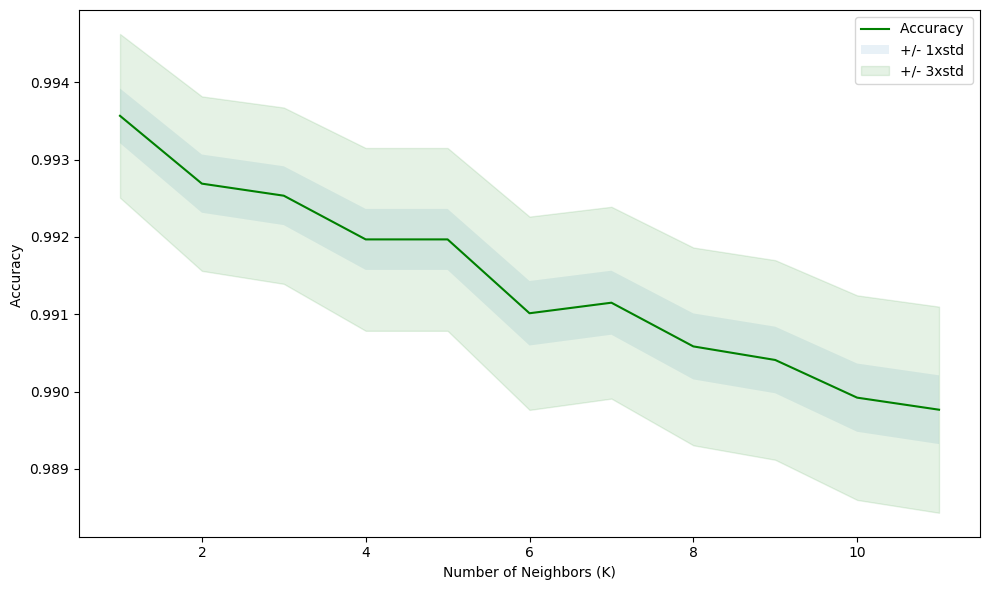

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   1.6s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   1.7s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   1.8s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.8s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.7s
[CV] END ..metric=euclidean, n_neighbors=2, weights=distance; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   1.8s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   1.8s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=   1.7s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.9s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=   0.8s
[CV] END ..metric=euclidean, n_neighbors=4, weig

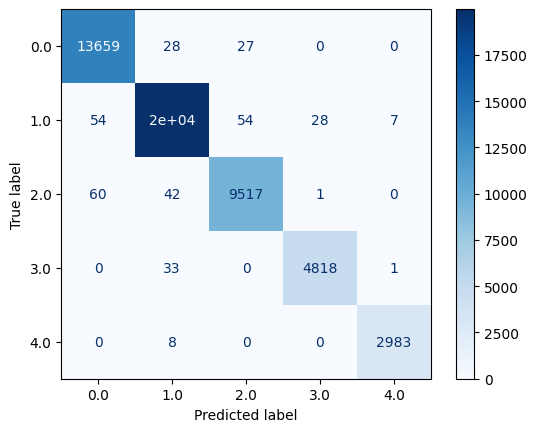

########################################################################
--- 85.24543523788452 seconds ---


In [61]:
knn = M.KNearetsNeighbor()

d:\environment\anaconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 93.27% 

########################################################################
Best solver is :  newton-cg
########################################################################
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     13952
         1.0       0.96      0.91      0.94     21232
         2.0       0.85      0.95      0.89      8579
         3.0       0.94      1.00      0.97      4552
         4.0       1.00      1.00      1.00      2977

    accuracy                           0.93     51292
   macro avg       0.94      0.96      0.94     51292
weighted avg       0.94      0.93      0.93     51292
 



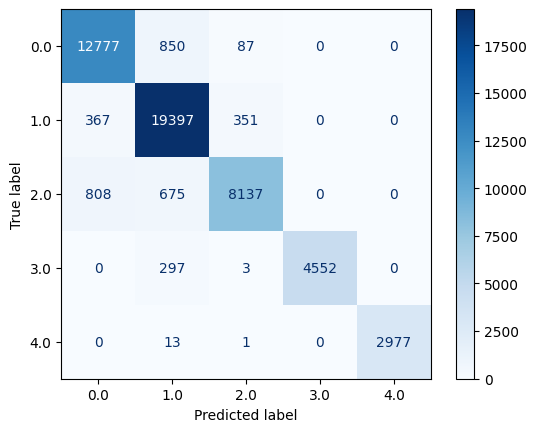

########################################################################
--- 27.598568439483643 seconds --- time for LogisticRegression


In [62]:
lr = M.LogisticRegression()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=2; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=3; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, max_leaf_nodes=4; total time=   0.3s
[CV] END ......criterion=gini, max_depth=2, ma

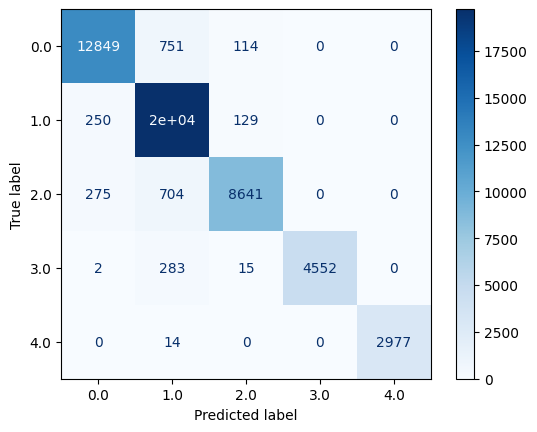

########################################################################
--- 752.9618582725525 seconds ---


In [63]:
dTree = M.DecisionTree()

Accuracy of RF is : 99.28% 

########################################################################
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     13698
         1.0       0.99      0.99      0.99     20179
         2.0       0.99      0.99      0.99      9599
         3.0       0.99      0.99      0.99      4837
         4.0       1.00      1.00      1.00      2979

    accuracy                           0.99     51292
   macro avg       0.99      0.99      0.99     51292
weighted avg       0.99      0.99      0.99     51292



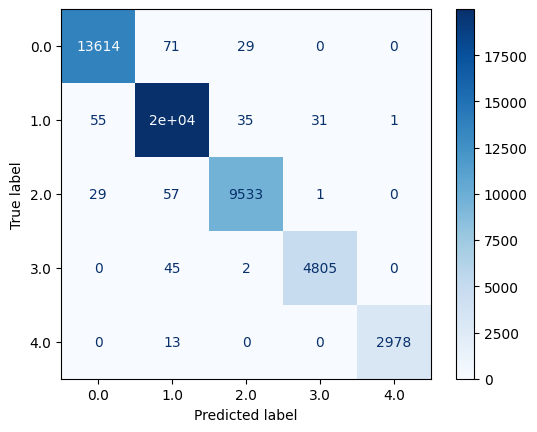

########################################################################
--- 358.6749608516693 seconds ---


In [64]:
rf = M.RandomForest()

Accuracy: 93.84%
######################################################################
Accuracy: 93.97%
######################################################################
Accuracy: 94.51%
######################################################################
Accuracy: 69.56%
######################################################################
Accuracy of SVM model 95.0% 

########################################################################
best kernel is :  rbf
########################################################################
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     13807
         1.0       0.99      0.92      0.95     21622
         2.0       0.85      0.98      0.91      8334
         3.0       0.94      1.00      0.97      4552
         4.0       1.00      1.00      1.00      2977

    accuracy                           0.95     51292
   macro avg       0.94      0.97      0.95     51292
weighted avg    

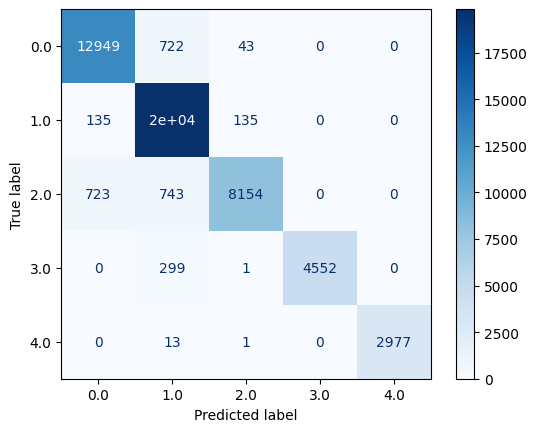

########################################################################
--- 978.6906251907349 seconds ---


In [65]:
svm = M.SupportVectorMachine()

# Validation model

protocol_type: object
service: object
flag: object
label: object


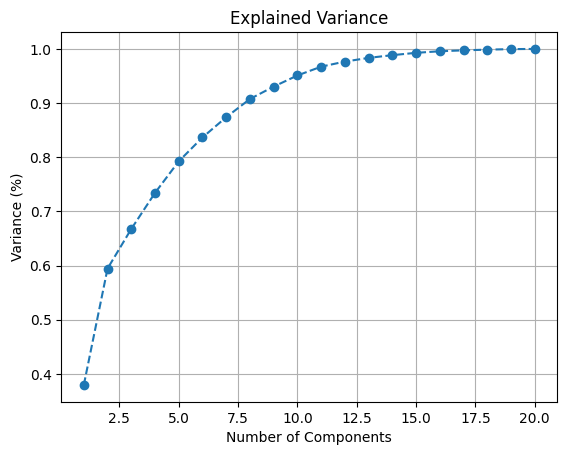

In [70]:

# attack_types = {}

    # 打开并读取文件
# with open("NSL-KDD//Attack_Types.csv", mode='r') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         key, value = row
#         attack_types[key] = value

    # print(attack_types)


    # 将原始攻击类型映射到大类
# df2['attack_class'] = df2.iloc[:,-2:-1].apply(lambda x: x.squeeze().map(attack_types).fillna('Other'))

    # missing_values = df.isnull().sum()

    # columns_with_missing_values = []

    # for column, count in missing_values.items():
    #     if count > 0:
    #         columns_with_missing_values.append(column)

data_file_path = './nsl-kdd/'
df = pd.read_csv(data_file_path+'KDDTest.csv')

df2 =  df.dropna()
df2.columns = df2.columns.str.strip()
    # 处理数据中的字符值
label_encoder = LabelEncoder()
object_cols = df2.select_dtypes(include=['object']).columns

for col in object_cols:
    print(f"{col}: {df2[col].dtype}")
    df2[col] = label_encoder.fit_transform(df2[col])

y = df2['label']
X = df2.drop(['label'], axis=1)


    # rus = RandomUnderSampler(random_state=42)
    # X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled, y_resampled = X, y

# y = y_resampled

X = X_resampled.replace([np.inf, -np.inf],np.nan).fillna(0)
# X = X.drop(['level'], axis=1)  

    # 标准化
scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)

X_scaler_df = pd.DataFrame(X_scaler, columns=X.columns)

# select features with high variance 除去常量特征即方差为0的特征
selector = VarianceThreshold(threshold=0)

selector.fit(X_scaler_df)

non_counstant_indices = selector.get_support(indices=True)

X_non_counstant = X_scaler_df.iloc[:, non_counstant_indices]

# select bast features with  ANOVA F 
# ANOVA F 统计量，它用于评估每个特征与目标变量 y 之间的线性关系。
k_bast = SelectKBest(score_func=f_classif ,k=20)
X_new = k_bast.fit_transform(X_non_counstant, y)

# 获取选择出的特征的列名
X_non_counstant.columns[k_bast.get_support()]

selected_features_name = X_non_counstant.columns[k_bast.get_support()]

X_selected = pd.DataFrame(X_new, columns=selected_features_name)

pca = PCA()

pca.fit(X_selected)

explained_variance_ratio = pca.explained_variance_ratio_

# 绘制累积解释方差比例的图表，以帮助确定保留多少个主成分。
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

n_components = 10

pca = PCA(n_components=n_components)

X_pca = pca.fit_transform(X_selected)

X_pca_df_test = pd.DataFrame(X_pca, columns=[ f'PC{i}' for i in range(n_components)])




In [71]:
def validate_model(model, X, y):
    predicted = model.predict(X)
    accuracy  = metrics.accuracy_score(y, predicted)
    print(f"Accuracy of { model.__class__.__name__ } ismodel {round(accuracy,2)*100}%", '\n')
    print("########################################################################")
    print(classification_report(predicted, y))
    cm = confusion_matrix(y, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()



In [72]:
classifiers = {
    'Random Forest': rf,
    'Logistic Regression':  lr,
    'Support Vector Machine': svm,
    'K-Nearest Neighbors':  knn,
    'Decision Tree':  dTree,
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, classifier in  classifiers.items():
    scores = cross_val_score(classifier, X_pca_df_test, y, cv=cv, scoring='accuracy')
    print(f'{name} Accuracy: {(round(scores.mean(),4) * 100)}%')
    print(f'{name} Accuracy Standard Deviation: {scores.std():.2f}')
    print(f'scores: {scores}')
    print('----------------------------------------------------')

Random Forest Accuracy: 96.58%
Random Forest Accuracy Standard Deviation: 0.00
scores: [0.96828565 0.9605234  0.96407186 0.96917277 0.96694765]
----------------------------------------------------
Logistic Regression Accuracy: 80.67999999999999%
Logistic Regression Accuracy Standard Deviation: 0.01
scores: [0.81858505 0.80572189 0.8003992  0.80150809 0.80789707]
----------------------------------------------------
Support Vector Machine Accuracy: 91.4%
Support Vector Machine Accuracy Standard Deviation: 0.00
scores: [0.91860723 0.91461521 0.91173209 0.91328454 0.91193434]
----------------------------------------------------
K-Nearest Neighbors Accuracy: 96.26%
K-Nearest Neighbors Accuracy Standard Deviation: 0.00
scores: [0.96030162 0.95830561 0.96207585 0.97094699 0.96140195]
----------------------------------------------------
Decision Tree Accuracy: 83.97%
Decision Tree Accuracy Standard Deviation: 0.00
scores: [0.84564205 0.83810157 0.83544023 0.83632735 0.8431677 ]
---------------